In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os , shutil
import cv2
import matplotlib.image  as mpimg
import seaborn as sns
plt.style.use('ggplot')

In [62]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count)+".jpg"
    os.rename(source , destination)
    count+=1

In [63]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count)+".jpg"
    os.rename(source , destination)
    count+=1

In [64]:
# EDA

In [88]:
# yes
list_Yes = os.listdir("brain_tumor_dataset/yes/")
length_yes = len(list_Yes);
print(length_yes)

# no
list_No = os.listdir("brain_tumor_dataset/no/")
length_no = len(list_No);
print(length_no)

155
98


In [89]:
# plot

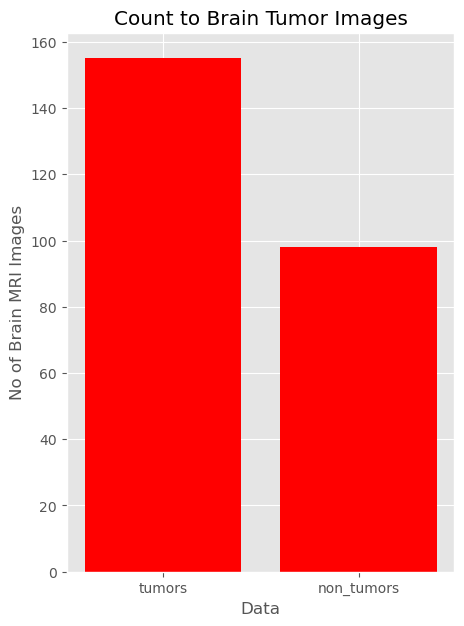

In [90]:
data = {'tumors' : length_yes , 'non_tumors' : length_no}

x = data.keys()
y = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(x , y  , color = "red")

plt.xlabel("Data")
plt.ylabel("No of Brain MRI Images")

plt.title("Count to Brain Tumor Images")
plt.show()

In [68]:
# Data Argumentation
# yes = 155 , no = 98
# its not balanced

# so we can just generate some more images generator

In [91]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten , Dense ,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau

In [82]:
def timing(sec_elapsed):
    h = int(sec_elapsed/(60*60))
    m = int(sec_elapsed%(60*60) / 60)
    s = sec_elapsed%60

    return f"{h}:{m}:{s}"

In [83]:
def argumented_data(file_dir , n_genetated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                       width_shift_range=0.1,
                       shear_range=0.1,
                       brightness_range=(0.3,1.0),
                       horizontal_flip= True,
                       vertical_flip=True,
                       fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir+ '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image , batch_size = 1 , save_to_dir = save_to_dir , save_prefix = save_prefix , save_format = "jpg"):
            i+=1
            if i>n_genetated_samples:
                break

In [84]:
import time

start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path =  'brain_tumor_dataset/no'

argumented_data_path = "brain_tumor_dataset/Agrumented/"
argumented_data(file_dir = yes_path , n_genetated_samples=6 , save_to_dir=argumented_data_path+'yes')
argumented_data(file_dir = no_path , n_genetated_samples=9 , save_to_dir=argumented_data_path+'no')

end_time = time.time()
execttion_time = end_time - start_time
print(timing(execttion_time))


0:1:7.022414684295654


In [92]:
def data_summary(main_path):
    yes_path = "brain_tumor_dataset/Agrumented/yes/"
    no_path = "brain_tumor_dataset/Agrumented/no/"

    m_pos = len(os.listdir(yes_path))
    m_neg = len(os.listdir(no_path))

    n = (m_pos + m_neg)
    pos_precentage = (m_pos*100)/n
    neg_precentage = (m_neg*100)/n
    print(f"Number of Samples:{n}")
    print(f"{m_pos} {pos_precentage}")
    print(f"{m_neg} {neg_precentage}")

In [93]:
data_summary(argumented_data_path)

Number of Samples:2065
1085 52.54237288135593
980 47.45762711864407


In [95]:
# yes
list_Yes = os.listdir("brain_tumor_dataset/Agrumented/yes/")
length_yes = len(list_Yes);
print(length_yes)

# no
list_No = os.listdir("brain_tumor_dataset/Agrumented/no/")
length_no = len(list_No);
print(length_no)

1085
980


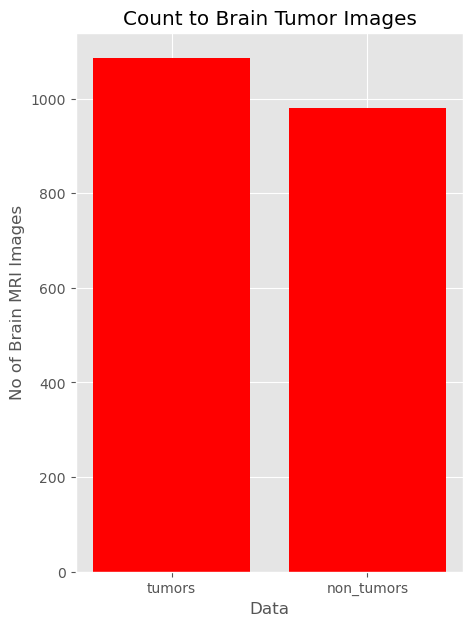

In [96]:
data = {'tumors' : length_yes , 'non_tumors' : length_no}

x = data.keys()
y = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(x , y  , color = "red")

plt.xlabel("Data")
plt.ylabel("No of Brain MRI Images")

plt.title("Count to Brain Tumor Images")
plt.show()

In [97]:
# Data PreProcessing

In [98]:
# Conver BGR TO GRAY
# Gausian Blur
# Threshold
# Find Contors

In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_brain_tumor(image, plot=False):
    # Convert the image to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding and morphological operations
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)

    # Find contours and grab them using imutils
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Get the largest contour
    c = max(cnts, key=cv2.contourArea)

    # Get the extreme points of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBottom = tuple(c[c[:, :, 1].argmax()][0])

    # Crop the image based on the extreme points
    new_image = image[extTop[1]:extBottom[1], extLeft[0]:extRight[0]]

    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 5))

        # Plot the original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')  # Hide axis ticks

        # Plot the cropped image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Tumor")
        plt.axis('off')  # Hide axis ticks

        # Show the plot
        plt.show()

    return new_image


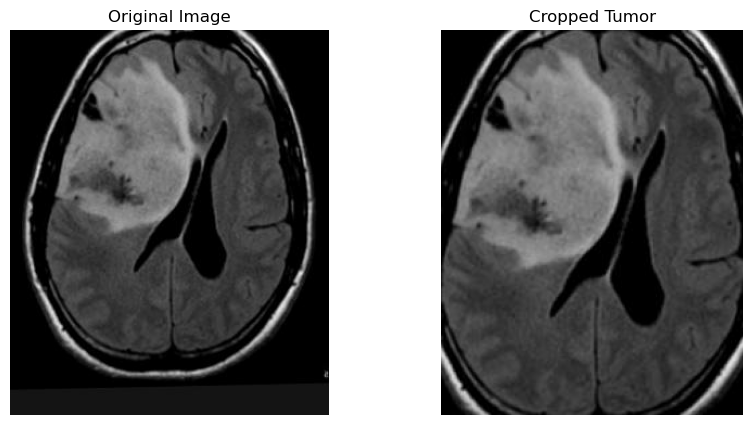

In [3]:
# Test the function with an image
img = cv2.imread('brain_tumor_dataset/Agrumented/yes/aug_Y_152_0_1187.jpg')
cropped_img = crop_brain_tumor(img, True)


In [4]:
# image loading 

In [5]:
def load_data(dir_list , image_size):
    x = []
    y = []

    image_width , image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image , plot = False)
            cv2.resize(image , dsize=(image_width , image_height) , interpolation=cv2.INTER_CUBIC)
            image = image/255.00
            x.append(image)
            if directory[-3:] == "yes":
                y.append(1)       
            else:
                y.append(0)

    x = np.array(x)
    y = np.array(y)

    x,y = shuffle(x,y)
    print(f"Number of Examples : {len(x)}")
    print(f"x shape : {x.shape}")
    print(f"y shape : {y.shape}")
    return x, y